In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sklearn
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
#import xgboost as xgb


os.getcwd()

'/Users/yojeremijenko-conel/Dropbox/Mac (3)/Documents/ocean-depth-characterization/EDA'

In [14]:
PROFILE_DATA_PATH = "../../DSI_bgcArgoProject/data/profileData.csv"
SAT_DATA_PATH = "../../DSI_bgcArgoProject/data/satData.csv"
drop_cols = ['LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD', 'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED']

profile_df = pd.read_csv(PROFILE_DATA_PATH)
sat_df = pd.read_csv(SAT_DATA_PATH)

out = pd.cut(profile_df.PRES, bins=50, labels=[i for i in range(50)])
profile_df['depth_bin'] = out

depth_profiles = profile_df[['float', 'cycleNumber', 'depth_bin', 'CHLA', 'BBP700', 'PRES']] \
    .groupby(['float', 'cycleNumber', 'depth_bin']).mean().reset_index().dropna()

df_depth = depth_profiles.merge(sat_df, on=['float', 'cycleNumber']).drop(drop_cols, axis=1).dropna()
df_depth['date'] = pd.to_datetime(df_depth.date, format='%Y-%m-%d %H:%M:%S')

In [15]:
df_depth.columns

Index(['float', 'cycleNumber', 'depth_bin', 'CHLA', 'BBP700', 'PRES', 'date',
       'latitude', 'longitude', 'elevation', 'MO_SAT_SST', 'MO_SAT_CHL',
       'MO_SAT_BBP'],
      dtype='object')

In [16]:
df_depth

,float,cycleNumber,depth_bin,CHLA,BBP700,PRES,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP
0,1902303,1,0,7.032535e-01,0.001806,12.500000,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
1,1902303,1,1,6.726779e-01,0.001777,33.692308,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
2,1902303,1,2,9.398182e-01,0.001749,55.785714,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
3,1902303,1,3,8.116276e-01,0.001665,78.214286,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
4,1902303,1,4,3.976900e-01,0.001163,99.466667,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2876118,7901001,15,40,4.585272e-18,0.000259,909.000000,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
2876119,7901001,15,41,4.585272e-18,0.000272,928.500000,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
2876120,7901001,15,42,-1.283063e-04,0.000288,949.250000,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
2876121,7901001,15,43,-1.786957e-03,0.000291,974.400000,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973


### Preprocessing

In [17]:
# bins_to_use = [0,1, 2, 3, 4, 5, 6, 8, 7, 10]
# df = df_depth[df_depth.depth_bin.isin(bins_to_use)]
# df["depth_bin"] = df.depth_bin.astype("int64").astype("category")

df = df_depth

In [18]:
# turn date into radians
df['date_doy'] = df.loc[:, 'date'].apply(lambda x: x.day_of_year)
df['date_doy_rad'] = df.loc[:, 'date_doy'] * (np.pi /182.625)

### Analysis of Merged Data

**Correlation Heatmap**

In [19]:
df.corr().style.background_gradient()

/var/folders/2s/dqvyr8r92_v2nfvgky0vvxbc0000gn/T/ipykernel_81678/3430435284.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient()


,float,cycleNumber,CHLA,BBP700,PRES,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,date_doy,date_doy_rad
float,1.000000,-0.009504,0.006993,0.031594,-0.011606,0.116615,-0.300851,0.325848,-0.352973,0.117792,0.127325,0.022898,0.022898
cycleNumber,-0.009504,1.000000,-0.005299,0.046958,-0.007074,0.029668,0.057088,-0.026315,0.036269,0.013936,-0.001912,-0.008400,-0.008400
CHLA,0.006993,-0.005299,1.000000,0.085228,-0.327605,-0.036423,0.021934,0.027225,-0.099710,0.104254,0.106637,-0.007703,-0.007703
BBP700,0.031594,0.046958,0.085228,1.000000,-0.049834,0.028949,-0.009691,-0.034801,0.026975,-0.010249,-0.005871,0.027676,0.027676
PRES,-0.011606,-0.007074,-0.327605,-0.049834,1.000000,-0.010671,-0.002605,-0.020706,0.000203,-0.003976,-0.000050,0.002010,0.002010
latitude,0.116615,0.029668,-0.036423,0.028949,-0.010671,1.000000,-0.063458,0.320092,0.231099,0.207204,-0.191803,0.015817,0.015817
longitude,-0.300851,0.057088,0.021934,-0.009691,-0.002605,-0.063458,1.000000,0.079541,-0.040756,-0.018343,0.015826,-0.002633,-0.002633
elevation,0.325848,-0.026315,0.027225,-0.034801,-0.020706,0.320092,0.079541,1.000000,-0.212597,0.194657,0.073600,0.011287,0.011287
MO_SAT_SST,-0.352973,0.036269,-0.099710,0.026975,0.000203,0.231099,-0.040756,-0.212597,1.000000,-0.281364,-0.428523,0.037673,0.037673
MO_SAT_CHL,0.117792,0.013936,0.104254,-0.010249,-0.003976,0.207204,-0.018343,0.194657,-0.281364,1.000000,0.471001,-0.023396,-0.023396


In [20]:
#df.shape

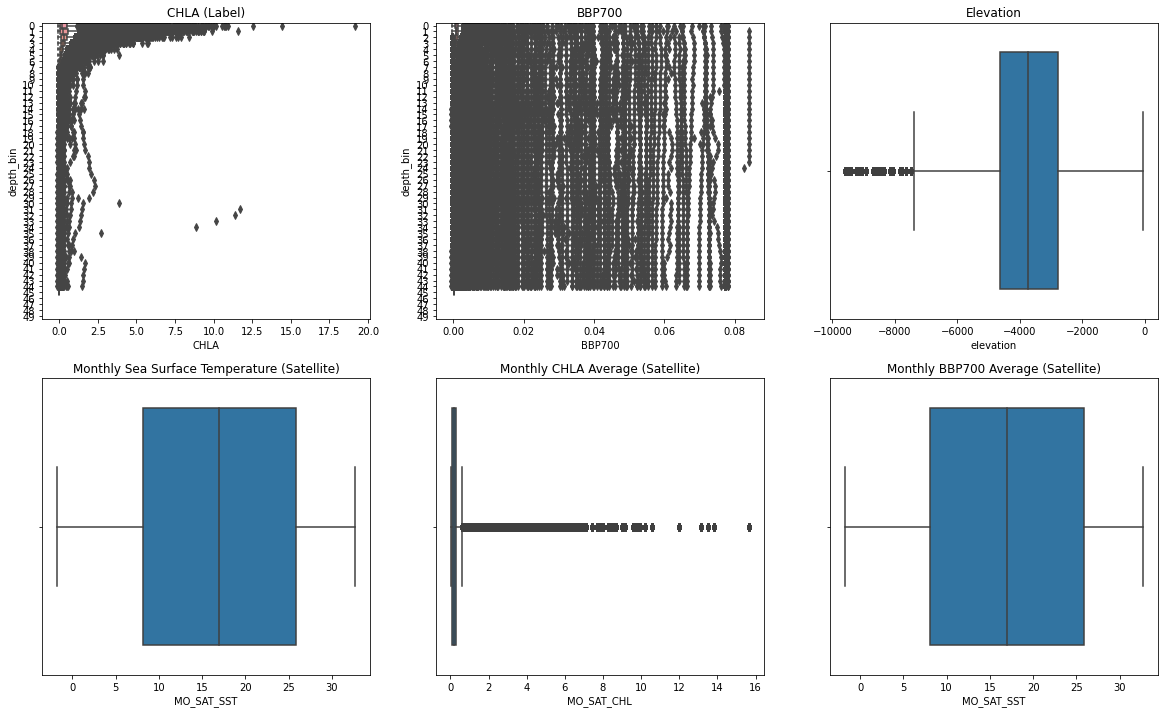

In [21]:
# boxplot of numerical variables
fig, ax = plt.subplots(2, 3, figsize=(20, 12))

sns.boxplot(data=df, x="CHLA", y="depth_bin", ax=ax[0, 0])
ax[0, 0].set_title("CHLA (Label)")

sns.boxplot(data=df, x="BBP700", y="depth_bin", ax=ax[0, 1])
ax[0, 1].set_title("BBP700")

sns.boxplot(data=df, x="elevation", ax=ax[0, 2])
ax[0, 2].set_title("Elevation")

sns.boxplot(data=df, x="MO_SAT_SST", ax=ax[1, 0])
ax[1, 0].set_title("Monthly Sea Surface Temperature (Satellite)")

sns.boxplot(data=df, x="MO_SAT_CHL", ax=ax[1, 1])
ax[1, 1].set_title("Monthly CHLA Average (Satellite)")

sns.boxplot(data=df, x="MO_SAT_SST", ax=ax[1, 2])
ax[1, 2].set_title("Monthly BBP700 Average (Satellite)")

plt.show()

In [22]:
# fig = px.density_mapbox(df, lat='latitude', lon='longitude', z='MO_SAT_CHL', radius=8, center=dict(lat=0, lon=180), zoom=0, mapbox_style='stamen-terrain')

# fig.show()

### Model Testing

In [23]:
def model_scoring(model, X, y, argument_dict=None, cv=5):
    # for sklearn API compatible gradient boosting models
    
    if not argument_dict:
        # train vanilla model
        cv_results = cross_validate(model, X, y, cv=cv,
                                    scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
                                    return_estimator=True,
                                    return_train_score=True)
        return cv_results
    else:
        # do a grid search
        gs_results = GridSearchCV(model,
                                  param_grid = [argument_dict], cv=cv,
                                  scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
                                  refit='neg_root_mean_squared_error',
                                  return_train_score=True)
        gs_results.fit(X, y)
        return gs_results

In [7]:
DATA_PATH = "../../DSI_bgcArgoProject/train_test_split.csv"
test_train = pd.read_csv(DATA_PATH)[['float', 'cycle', 'train']]

Index(['float', 'cycleNumber', 'depth_bin', 'CHLA', 'BBP700', 'PRES', 'date',
       'latitude', 'longitude', 'elevation', 'MO_SAT_SST', 'MO_SAT_CHL',
       'MO_SAT_BBP', 'date_doy', 'date_doy_rad'],
      dtype='object')

In [36]:
df['float_cycle'] = [str(x) + '_' + str(y) for x,y in df[['float', 'cycleNumber']].values]

In [38]:
test_train['float_cycle'] = [str(x) + '_' + str(y) for x,y in test_train[['float', 'cycle']].values]

In [39]:
test_train

,float,cycle,train,float_cycle
0,5904858,176,0,5904858_176
1,5904857,76,0,5904857_76
2,5904857,82,0,5904857_82
3,5904672,8,0,5904672_8
4,5905372,64,0,5905372_64
...,...,...,...,...
58445,7901001,24,1,7901001_24
58446,7901001,25,1,7901001_25
58447,7901001,26,1,7901001_26
58448,7901001,27,1,7901001_27


In [40]:
te = test_train[test_train.train == 0]
tr = test_train[test_train.train == 1]

In [41]:
te

,float,cycle,train,float_cycle
0,5904858,176,0,5904858_176
1,5904857,76,0,5904857_76
2,5904857,82,0,5904857_82
3,5904672,8,0,5904672_8
4,5905372,64,0,5905372_64
...,...,...,...,...
11461,2902755,274,0,2902755_274
11462,2902755,291,0,2902755_291
11463,2902755,265,0,2902755_265
11464,2902755,316,0,2902755_316


In [44]:
train = df[df.float_cycle.isin(tr.float_cycle)]
test = df[df.float_cycle.isin(te.float_cycle)]

X_train = train[["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]
y_train = train["CHLA"]

X_test = test[["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]
y_test = test["CHLA"]

In [45]:
Xc_boost = df[["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]
yc_boost = df["CHLA"]

X_tr, X_te, y_tr, y_te = train_test_split(Xc_boost, yc_boost, test_size=0.15, random_state=23)

In [46]:
te

,float,cycle,train,float_cycle
0,5904858,176,0,5904858_176
1,5904857,76,0,5904857_76
2,5904857,82,0,5904857_82
3,5904672,8,0,5904672_8
4,5905372,64,0,5905372_64
...,...,...,...,...
11461,2902755,274,0,2902755_274
11462,2902755,291,0,2902755_291
11463,2902755,265,0,2902755_265
11464,2902755,316,0,2902755_316


In [47]:
df['float_cycle']

0           1902303_1
1           1902303_1
2           1902303_1
3           1902303_1
4           1902303_1
              ...    
2876118    7901001_15
2876119    7901001_15
2876120    7901001_15
2876121    7901001_15
2876122    7901001_15
Name: float_cycle, Length: 2245754, dtype: object

In [49]:
X_train

,latitude,longitude,date_doy_rad,PRES,MO_SAT_CHL,MO_SAT_BBP,MO_SAT_SST
45,49.096000,-14.617000,2.167505,12.500000,0.782180,0.003081,12.466026
46,49.096000,-14.617000,2.167505,33.416667,0.782180,0.003081,12.466026
47,49.096000,-14.617000,2.167505,55.937500,0.782180,0.003081,12.466026
48,49.096000,-14.617000,2.167505,78.687500,0.782180,0.003081,12.466026
49,49.096000,-14.617000,2.167505,100.533333,0.782180,0.003081,12.466026
...,...,...,...,...,...,...,...
2876118,16.523053,-23.800818,1.548218,909.000000,0.162496,0.000973,22.133210
2876119,16.523053,-23.800818,1.548218,928.500000,0.162496,0.000973,22.133210
2876120,16.523053,-23.800818,1.548218,949.250000,0.162496,0.000973,22.133210
2876121,16.523053,-23.800818,1.548218,974.400000,0.162496,0.000973,22.133210


In [50]:
nn_scores = []

In [51]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=7, input_dim=7, kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=14, kernel_initializer='normal', activation='relu'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')



Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-10 12:15:46.164196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-10 12:15:46.164859: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [52]:
%%time
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 256, epochs = 20, verbose=1)

2022-11-10 12:15:54.842584: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-10 12:15:55.035977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
6284/6284 [==============================] - 30s 5ms/step - loss: 0.0233
Epoch 2/20
6284/6284 [==============================] - 28s 4ms/step - loss: 0.0210
Epoch 3/20
6284/6284 [==============================] - 28s 4ms/step - loss: 0.0199
Epoch 4/20
6284/6284 [==============================] - 27s 4ms/step - loss: 0.0185
Epoch 5/20
6284/6284 [==============================] - 32s 5ms/step - loss: 0.0183
Epoch 6/20
6284/6284 [==============================] - 30s 5ms/step - loss: 0.0181
Epoch 7/20
6284/6284 [==============================] - 29s 5ms/step - loss: 0.0179
Epoch 8/20
6284/6284 [==============================] - 28s 4ms/step - loss: 0.0178
Epoch 9/20
6284/6284 [==============================] - 29s 5ms/step - loss: 0.0177
Epoch 10/20
6284/6284 [==============================] - 35s 6ms/step - loss: 0.0177
Epoch 11/20
6284/6284 [==============================] - 28s 5ms/step - loss: 0.0175
Epoch 12/20
6284/6284 [==============================] - 29s 5ms/step - lo

In [21]:
# from sklearn.metrics import r2_score

# y_pred = model.predict(X_te)
# r2 = r2_score(y_t, y_pred)
# print(r2)
# nn_scores.append(r2)
# nn_scores

2022-11-09 12:37:11.517849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.584351486408071


[0.584351486408071]

In [53]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
nn_scores.append(r2)
nn_scores


2022-11-10 12:25:39.123403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.6057302277119987


[0.6057302277119987]

In [22]:
floats = [5906031, 6903273, 3902124]

In [23]:
df[df.float.isin(floats)]

Xc_float = df[df.float.isin(floats)][["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]
yc_float = df[df.float.isin(floats)]["CHLA"]


In [24]:
depth_list = []
for i in range(0,1000, 20):
     mask = (X_te["PRES"] >= i) & (X_te['PRES']< i +20)
     depth_list.append(mask)
    


In [54]:
depth_list = []
for i in range(0,1000, 20):
     mask = (X_test["PRES"] >= i) & (X_test['PRES']< i +20)
     depth_list.append(mask)

In [25]:
r2_list = []
for i in depth_list:
    X_depth = X_te[i]
    y_depth = y_te[i]
    print(X_depth.shape)
    y_pred = model.predict(X_depth)
    r2 = r2_score(y_depth, y_pred)
    print(r2)
    r2_list.append(r2)

(7694, 7)


2022-11-09 12:37:32.044912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.4863366902050573
(7688, 7)
0.4786066565360998
(7813, 7)
0.297496666385049
(7758, 7)
0.2471741979764912
(1651, 7)
-0.018305398943036177
(6153, 7)
0.20252812855981495
(7899, 7)
0.054606052612111156
(7642, 7)
0.02492409877301094
(7541, 7)
-0.062474676834848086
(7925, 7)
-0.11761360921824404
(7984, 7)
-0.04359412916395433
(7641, 7)
-0.00520613392170044
(7324, 7)
-0.002943548114412886
(5814, 7)
-0.010332865079526243
(2497, 7)
-4.7876775156829865e-05
(7301, 7)
-0.021599490119706966
(7649, 7)
-0.029570343397563148
(7721, 7)
-0.039152231676610194
(7696, 7)
-0.07503015669698043
(7613, 7)
-0.10630856571351543
(7635, 7)
-0.054943130742352464
(7272, 7)
-0.040270451383508155
(6677, 7)
-0.17350229827431152
(1985, 7)
-0.00571558906966918
(6830, 7)
-0.13507529500474913
(7261, 7)
-0.17617946828364794
(7320, 7)
-0.1443788694740582
(7457, 7)
-0.13591003943341096
(7552, 7)
-0.17721437225099446
(7467, 7)
-0.13032326021088836
(7399, 7)
-0.14134815726333527
(6674, 7)
-0.10802807606521836
(3043, 7)
-0.04499

In [55]:
r2_list = []
for i in depth_list:
    X_depth = X_test[i]
    y_depth = y_test[i]
    print(X_depth.shape)
    y_pred = model.predict(X_depth)
    r2 = r2_score(y_depth, y_pred)
    print(r2)
    r2_list.append(r2)

(8876, 7)
0.522688415693574
(8874, 7)
0.5007937810855279
(8878, 7)
0.36997908439767313
(8866, 7)
0.21927355680395488
(2053, 7)
0.05305640178397897
(6833, 7)
0.07877111936981651
(8876, 7)
0.03640254795574993
(8876, 7)
0.03944219085151335
(8876, 7)
-0.01089427651578867
(8876, 7)
-0.13195891040104613
(8876, 7)
-0.1296127142196477
(8876, 7)
-0.09059479551421967
(8640, 7)


2022-11-10 12:27:06.291838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


-0.0812303376908452
(6558, 7)
-0.10442786112265945
(2957, 7)
-0.06279242446430211
(8504, 7)
-0.11200108731427783
(8851, 7)
-0.08708170390334136
(8867, 7)
-0.09311527367553696
(8851, 7)
-0.07221336624517805
(8802, 7)
-0.08492386840381005
(8743, 7)
-0.12937601031314783
(8389, 7)
-0.1754472447208515
(7735, 7)
-0.21653047314913287
(2188, 7)
-0.09425692090549509
(7890, 7)
-0.2331521658545217
(8381, 7)
-0.217420005159205
(8555, 7)
-0.22787175818479888
(8578, 7)
-0.24545170707530461
(8527, 7)
-0.24810590239633923
(8530, 7)
-0.25822599818090075
(8536, 7)
-0.2712253619266338
(7750, 7)
-0.3052705452559563
(3584, 7)
-0.2843241040813489
(6093, 7)
-0.29833756809688894
(8086, 7)
-0.34382243951879765
(8497, 7)
-0.35069878334442817
(8461, 7)
-0.3669285686111896
(8494, 7)
-0.39355131921747155
(8446, 7)
-0.41369892262505825
(8439, 7)
-0.4463561706220449
(8181, 7)
-0.4772366133300403
(3933, 7)
-0.4286960380861071
(5472, 7)
-0.5474432376339589
(7804, 7)
-0.5584085872083822
(8284, 7)
-0.580333522360813
(83

In [42]:
len(depth_list)

50

In [58]:
r2_list

[0.4863366902050573,
 0.4786066565360998,
 0.297496666385049,
 0.2471741979764912,
 -0.018305398943036177,
 0.20252812855981495,
 0.054606052612111156,
 0.02492409877301094,
 -0.062474676834848086,
 -0.11761360921824404,
 -0.04359412916395433,
 -0.00520613392170044,
 -0.002943548114412886,
 -0.010332865079526243,
 -4.7876775156829865e-05,
 -0.021599490119706966,
 -0.029570343397563148,
 -0.039152231676610194,
 -0.07503015669698043,
 -0.10630856571351543,
 -0.054943130742352464,
 -0.040270451383508155,
 -0.17350229827431152,
 -0.00571558906966918,
 -0.13507529500474913,
 -0.17617946828364794,
 -0.1443788694740582,
 -0.13591003943341096,
 -0.17721437225099446,
 -0.13032326021088836,
 -0.14134815726333527,
 -0.10802807606521836,
 -0.04499930903113447,
 -0.11338955802405204,
 -0.19898680753781384,
 -0.132291130951532,
 -0.14361658281171552,
 -0.121249627322642,
 -0.1340577775488625,
 -0.13554712580994743,
 -0.14985934722395622,
 -0.14870281215498404,
 -0.03143339165193826,
 -0.082787118091

In [47]:
depth_list[0]

587967     False
553785     False
159043     False
2761132    False
1620186    False
           ...  
1661578    False
884972     False
77210      False
790493     False
946229     False
Name: PRES, Length: 336864, dtype: bool

<BarContainer object of 50 artists>

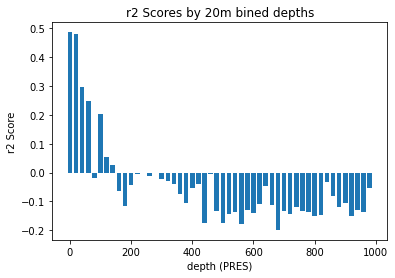

In [57]:
fig, ax = plt.subplots()
ax.set_title('r2 Scores by 20m bined depths')
ax.set_ylabel('r2 Score')
ax.set_xlabel('depth (PRES)')
plt.bar(x = np.array(range(0,1000, 20)), height = np.array(r2_list), width= 15, label = 'r2 Scores for 20m depth bins')

<BarContainer object of 50 artists>

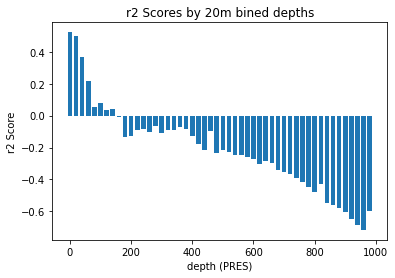

In [56]:
fig, ax = plt.subplots()
ax.set_title('r2 Scores by 20m bined depths')
ax.set_ylabel('r2 Score')
ax.set_xlabel('depth (PRES)')
plt.bar(x = np.array(range(0,1000, 20)), height = np.array(r2_list), width= 15, label = 'r2 Scores for 20m depth bins')

In [36]:
len(r2_list)

50

In [30]:
X_te#[depth_list[0]]

,latitude,longitude,date_doy_rad,PRES,MO_SAT_CHL,MO_SAT_BBP,MO_SAT_SST
587967,22.524000,-157.940000,2.700781,593.615385,0.059607,0.001811,25.523618
553785,33.928000,-124.533000,6.055253,817.000000,0.594331,0.002719,13.939044
159043,-4.472897,81.615610,3.853343,547.250000,0.087997,0.001522,29.861478
2761132,69.372045,-2.165583,1.875064,347.133333,0.235003,0.001173,5.142934
1620186,22.957093,-69.451035,0.825716,257.190476,0.052157,0.001477,25.190694
...,...,...,...,...,...,...,...
1661578,20.607273,-40.468623,3.302865,123.000000,0.047639,0.001364,25.800025
884972,-28.690000,-107.423000,3.457687,638.000000,0.058149,0.001288,20.363910
77210,13.993833,57.490205,0.911728,630.500000,0.301602,0.001394,26.006541
790493,-48.672000,-178.854000,1.100955,33.928571,0.491553,0.002944,11.889089


In [23]:
float_pred = model.predict(Xc_float)

2022-10-18 13:31:56.011859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [57]:
Xc_float1 = df[df.float == 5906031][["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]
yc_float1 = df[df.float == 5906031]["CHLA"]

In [58]:
float_pred1 = model.predict(Xc_float1)

In [59]:
r2_score(yc_float1, float_pred1)

0.717724715960768

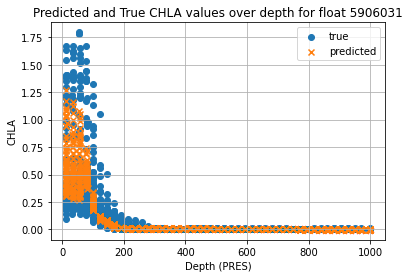

In [60]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
plt.grid()
ax.scatter(Xc_float1['PRES'], yc_float1 , marker="o", label = 'true')
ax.set_xlabel("Depth (PRES)")
ax.set_ylabel("CHLA")
ax.set_title("Predicted and True CHLA values over depth for float 5906031")
ax.scatter(Xc_float1['PRES'], float_pred1, marker="x", label = 'predicted')
ax.legend(loc="upper right")

plt.show()

0.7235987851747268


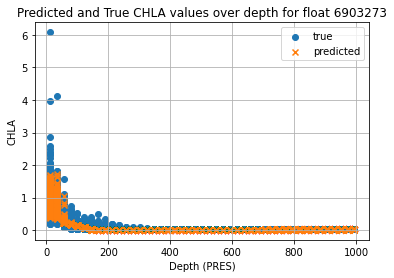

In [28]:
Xc_float2 = df[df.float == 6903273][["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]
yc_float2 = df[df.float == 6903273]["CHLA"]
float_pred2 = model.predict(Xc_float2)
print(r2_score(yc_float2, float_pred2))
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
plt.grid()

ax.scatter(Xc_float2['PRES'], yc_float2 , marker="o", label = 'true')
ax.set_xlabel("Depth (PRES)")
ax.set_ylabel("CHLA")
ax.set_ylabel("CHLA")
ax.set_title("Predicted and True CHLA values over depth for float 6903273")
ax.scatter(Xc_float2['PRES'], float_pred2, marker="x", label = 'predicted')
ax.legend(loc="upper right")

plt.show()

0.09006625869950835


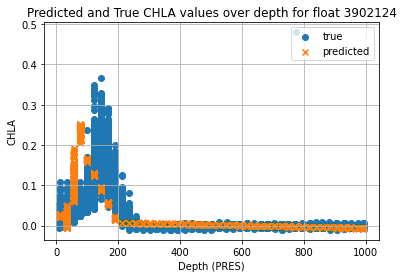

In [61]:
Xc_float3 = df[df.float == 3902124][["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]
yc_float3 = df[df.float == 3902124]["CHLA"]
float_pred3 = model.predict(Xc_float3)
print(r2_score(yc_float3, float_pred3))
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
plt.grid()

ax.scatter(Xc_float3['PRES'], yc_float3 , marker="o", label = 'true')
ax.set_xlabel("Depth (PRES)")
ax.set_ylabel("CHLA")
ax.set_ylabel("CHLA")
ax.set_title("Predicted and True CHLA values over depth for float 3902124")
ax.scatter(Xc_float3['PRES'], float_pred3, marker="x", label = 'predicted')
ax.legend(loc="upper right")

plt.show()

In [30]:
df[df.float == 3902124].cycleNumber.unique()



array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

0.744537602951016


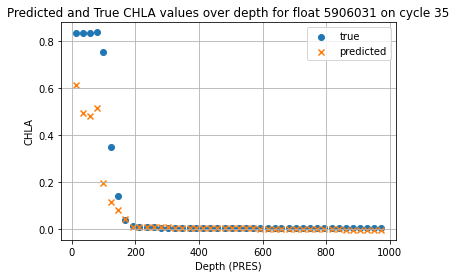

In [62]:
Xc_float1 = df[df.float == 5906031][["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST", 'cycleNumber']]
cycleNum = np.random.choice(Xc_float1.cycleNumber.unique())
Xc_float1 = Xc_float1[Xc_float1.cycleNumber == cycleNum]
yc_float1 = df.loc[list(Xc_float1[Xc_float1.cycleNumber == cycleNum].index)]["CHLA"]
Xc_float1 = Xc_float1.drop("cycleNumber", axis = 1)
float_pred1 = model.predict(Xc_float1)
print(r2_score(yc_float1, float_pred1))
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
plt.grid()
ax.scatter(Xc_float1['PRES'], yc_float1 , marker="o", label = 'true')
ax.set_xlabel("Depth (PRES)")
ax.set_ylabel("CHLA")
ax.set_ylabel("CHLA")
ax.set_title("Predicted and True CHLA values over depth for float 5906031 on cycle " + str(cycleNum))
ax.scatter(Xc_float1['PRES'], float_pred1, marker="x", label = 'predicted')
ax.legend(loc="upper right")

plt.show()

0.5647473532115823


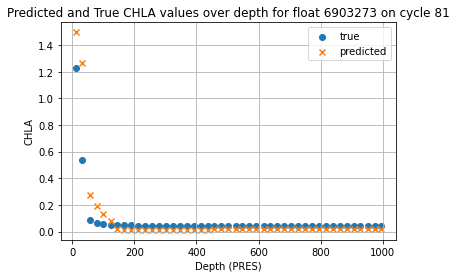

In [33]:


Xc_float2 = df[df.float == 6903273][["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST", 'cycleNumber']]
cycleNum = np.random.choice(Xc_float2.cycleNumber.unique())
Xc_float2 = Xc_float2[Xc_float2.cycleNumber == cycleNum]
yc_float2 = df.loc[list(Xc_float2[Xc_float2.cycleNumber == cycleNum].index)]["CHLA"]
Xc_float2 = Xc_float2.drop("cycleNumber", axis = 1)
float_pred2 = model.predict(Xc_float2)
print(r2_score(yc_float2, float_pred2))
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
plt.grid()

ax.scatter(Xc_float2['PRES'], yc_float2 , marker="o", label = 'true')
ax.set_xlabel("Depth (PRES)")
ax.set_ylabel("CHLA")
ax.set_ylabel("CHLA")
ax.set_title("Predicted and True CHLA values over depth for float 6903273 on cycle " + str(cycleNum))
ax.scatter(Xc_float2['PRES'], float_pred2, marker="x", label = 'predicted')
ax.legend(loc="upper right")

plt.show()

-0.139353857485226


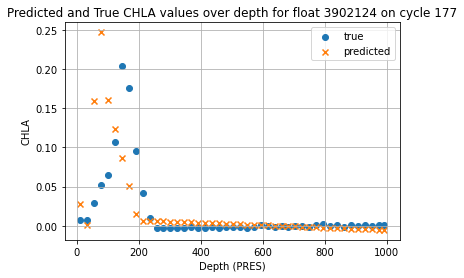

In [63]:
Xc_float3 = df[df.float == 3902124][["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST", 'cycleNumber']]
cycleNum = np.random.choice(Xc_float3.cycleNumber.unique())
Xc_float3 = Xc_float3[Xc_float3.cycleNumber == cycleNum]
yc_float3 = df.loc[list(Xc_float3[Xc_float3.cycleNumber == cycleNum].index)]["CHLA"]
Xc_float3 = Xc_float3.drop("cycleNumber", axis = 1)
float_pred3 = model.predict(Xc_float3)
print(r2_score(yc_float3, float_pred3))
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
plt.grid()

ax.scatter(Xc_float3['PRES'], yc_float3 , marker="o", label = 'true')
ax.set_xlabel("Depth (PRES)")
ax.set_ylabel("CHLA")
ax.set_ylabel("CHLA")
ax.set_title("Predicted and True CHLA values over depth for float 3902124 on cycle " + str(cycleNum))
ax.scatter(Xc_float3['PRES'], float_pred3, marker="x", label = 'predicted')
ax.legend(loc="upper right")

plt.show()

In [126]:
df.loc[list(Xc_float2[Xc_float2.cycleNumber == cycleNum].index)]

,float,cycleNumber,depth_bin,CHLA,BBP700,PRES,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,date_doy,date_doy_rad
2745997,6903273,25,0,1.246800,0.001506,12.916667,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995
2745998,6903273,25,1,1.055587,0.001381,33.437500,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995
2745999,6903273,25,2,0.351360,0.000947,56.533333,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995
2746000,6903273,25,3,0.153471,0.000750,78.928571,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995
2746001,6903273,25,4,0.112275,0.000730,100.562500,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995
2746002,6903273,25,5,0.091688,0.000701,123.562500,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995
2746003,6903273,25,6,0.063986,0.000673,145.642857,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995
2746004,6903273,25,7,0.048714,0.000660,167.928571,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995
2746005,6903273,25,8,0.049453,0.000630,189.866667,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995
2746006,6903273,25,9,0.049300,0.000616,212.142857,2016-06-11 21:40:15,68.721,-1.334,-3406.0,8.015268,0.60267,0.002428,163,2.803995


In [134]:
yc_float2

2749417    0.309600
2749418    0.308831
2749419    0.307631
2749420    0.248462
2749421    0.093843
2749422    0.049106
2749423    0.039925
2749424    0.038750
2749425    0.036031
2749426    0.036000
2749427    0.036722
2749428    0.039008
2749429    0.039400
2749430    0.037077
2749431    0.037600
2749432    0.038797
2749433    0.038422
2749434    0.041354
2749435    0.038750
2749436    0.037240
2749437    0.037636
2749438    0.041223
2749439    0.040011
2749440    0.041067
2749441    0.041970
2749442    0.041509
2749443    0.040154
2749444    0.039600
2749445    0.039600
2749446    0.039600
2749447    0.040154
2749448    0.041858
2749449    0.042162
2749450    0.042717
2749451    0.040325
2749452    0.038703
2749453    0.036870
2749454    0.036000
2749455    0.037015
2749456    0.039170
2749457    0.041176
2749458    0.042969
2749459    0.043200
2749460    0.043200
2749461    0.043200
Name: CHLA, dtype: float64

In [108]:
Xc_float2 = df[df.float == 6903273 && df.cycleNumber == cycleNum][["latitude", "longitude", "date_doy_rad", "PRES", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]


SyntaxError: invalid syntax (2613248687.py, line 1)

In [111]:
df[df.float == 6903273 and df.cycleNumber == cycleNum]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [18]:
gbr = GradientBoostingRegressor()

gbr_scoring = model_scoring(gbr, X_tr, y_tr)

KeyboardInterrupt: 

In [ ]:
xgbr = xgb.XGBRegressor()

xgbr_scoring = model_scoring(xgbr, X_tr.to_numpy(), y_tr.to_numpy())

In [ ]:
xgbr_scoring["test_r2"]

In [3]:
([0.7030797 , 0.68809621, 0.69670025, 0.66998076, 0.69835647])

[0.7030797, 0.68809621, 0.69670025, 0.66998076, 0.69835647]

In [28]:
df

,float,cycleNumber,depth_bin,CHLA,BBP700,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP
0,1902303,1,0,0.703254,0.001806,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
2,1902303,1,2,0.939818,0.001749,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
4,1902303,1,4,0.397690,0.001163,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
6,1902303,1,6,0.102356,0.000627,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
8,1902303,1,8,0.039634,0.000378,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
...,...,...,...,...,...,...,...,...,...,...,...,...
2876080,7901001,15,2,0.392574,0.001151,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
2876082,7901001,15,4,0.047977,0.000516,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
2876084,7901001,15,6,0.000839,0.000426,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
2876086,7901001,15,8,0.001742,0.000421,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973


# Running same model on test/train data split over cycle number

In [3]:
DATA_PATH = "../../DSI_bgcArgoProject/train_test_split.csv"
df2 = pd.read_csv(DATA_PATH)

In [4]:
df2

,float,cycle,latitude,longitude,seasonality,lon_bin,lat_bin,train
0,5904858,176,-71.834,-172.491,2,"(-180, -170]","(-80, -70]",0
1,5904857,76,-70.113,-179.243,3,"(-180, -170]","(-80, -70]",0
2,5904857,82,-70.287,-178.637,4,"(-180, -170]","(-80, -70]",0
3,5904672,8,-63.592,-170.051,1,"(-180, -170]","(-70, -60]",0
4,5905372,64,-62.139,-178.874,2,"(-180, -170]","(-70, -60]",0
...,...,...,...,...,...,...,...,...
58445,7901001,24,16.953,-23.772,2,"(-30, -20]","(10, 20]",1
58446,7901001,25,17.122,-23.670,2,"(-30, -20]","(10, 20]",1
58447,7901001,26,17.271,-23.511,2,"(-30, -20]","(10, 20]",1
58448,7901001,27,17.316,-23.379,2,"(-30, -20]","(10, 20]",1


In [5]:
df2[['float', 'cycle', 'train']]

,float,cycle,train
0,5904858,176,0
1,5904857,76,0
2,5904857,82,0
3,5904672,8,0
4,5905372,64,0
...,...,...,...
58445,7901001,24,1
58446,7901001,25,1
58447,7901001,26,1
58448,7901001,27,1
